# Textblob Sentiment Analysis

In [26]:
# Importing libraries
import pandas as pd
import numpy as np
from textblob import TextBlob 
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(12,10)})
sns.set_style('white')

from tqdm import tqdm
tqdm.pandas()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [10]:
# Importing price data

##########################
get_price_info = True
##########################

if get_price_info:
    import mysql.connector
    token_metrics_db = mysql.connector.connect(user='mluser', password='ml@t0kenMetrics',
                                  host='tokenmetrics-restored-27-05.cxuzrhvtziar.us-east-1.rds.amazonaws.com',
                                  database='tokenmetrics')


    crypto_prices = pd.read_sql_query("SELECT * FROM ico_price_daily_summaries WHERE currency = 'USD'", token_metrics_db)
    token_metrics_db.close()

### User Input
Please input the name of the csv file below:

In [11]:
####################################################
filename =  "../Data/Processed_data/Bitcoin_5794_clean.csv"
coin_symbol = "BTC"
####################################################

# Extracing twitter data
data = pd.read_csv(filename)
data['date'] = pd.to_datetime(data.date)
data['day'] = data.date.apply(lambda x: x.date())
data = data[['username', 'date', 'day', 'hashtags', 'mentions', 'retweets', 'favorites','text']]
data = data.dropna(subset=['text'])


# Extract Coin prices
if get_price_info:
    prices = crypto_prices[crypto_prices.ico_symbol == coin_symbol]
    prices.date = pd.to_datetime(prices.date)
    # Updating the range of prices
    masksup = prices.date.apply(lambda x: x.date()) >= data.date.apply(lambda x: x.date).min()
    maskinf = prices.date.apply(lambda x: x.date()) <= data.date.apply(lambda x: x.date).max()
    
    
data.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,username,date,day,hashtags,mentions,retweets,favorites,text
0,bitlivewireio,2020-08-17 22:12:08+00:00,2020-08-17,#wavesworld #btc #btc #fintech #crypto #stakin...,NaN,25,34,"Waves World Loyalty Staking Payout 136 1,163.5..."
1,amelia29506634,2020-08-17 20:02:47+00:00,2020-08-17,#VSN #Vision #giveaway #Bitcoin #Bitcoin #BTC ...,NaN,0,3,VSN Ⓥ is coming! Check out our new whitepaper ...
2,intotheblock,2020-08-17 20:00:18+00:00,2020-08-17,#Bitcoin #Bitcoin #intotheblockpredicts #crypt...,NaN,0,3,Bitcoin price will increase from a baseline of...
3,TokenJay,2020-08-17 19:31:03+00:00,2020-08-17,NaN,NaN,1,2,Bitcoin Investors Swap for Ethereum ‘Wrapped B...
4,webnowcompany,2020-08-17 19:02:39+00:00,2020-08-17,#DEFI #BTC #BTC,NaN,0,0,DEFI BTC Bitcoin Press Release: Crypto Price I...


### Sentiment

In [12]:
# Building Sentiment helper Function

def getSentiment(dataframe, col_text='text'):
    '''
    Function which adds two columns to a Dataframe containing a text column 'col_text'.
    The first column is the polarity of the text.
    The second column is the sentiment of the text.
    
    dataframe: the dataframe to add the columns
    
    col_text: the name of the column in the dataframe which contains the text information.
    '''
    df = dataframe.copy()
    
    def get_senti(score):
        if score < -0.5:
            return 'very negative'
        elif score < 0:
            return 'negative'
        elif score == 0:
            return 'neutral'
        elif score < 0.5:
            return 'positive'
        else:
            return 'very positive'
    
    df['polarity'] = df[col_text].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment'] = df.polarity.progress_apply(get_senti)
    df['subjectivity'] = df[col_text].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)

    return df


In [13]:
sentiment_data = getSentiment(data)
sentiment_data.head()

100%|██████████| 5794/5794 [00:03<00:00, 1870.25it/s]


,username,date,day,hashtags,mentions,retweets,favorites,text,polarity,sentiment,subjectivity
0,bitlivewireio,2020-08-17 22:12:08+00:00,2020-08-17,#wavesworld #btc #btc #fintech #crypto #stakin...,NaN,25,34,"Waves World Loyalty Staking Payout 136 1,163.5...",0.000000,neutral,0.750000
1,amelia29506634,2020-08-17 20:02:47+00:00,2020-08-17,#VSN #Vision #giveaway #Bitcoin #Bitcoin #BTC ...,NaN,0,3,VSN Ⓥ is coming! Check out our new whitepaper ...,0.185606,positive,0.469697
2,intotheblock,2020-08-17 20:00:18+00:00,2020-08-17,#Bitcoin #Bitcoin #intotheblockpredicts #crypt...,NaN,0,3,Bitcoin price will increase from a baseline of...,0.116667,positive,0.293333
3,TokenJay,2020-08-17 19:31:03+00:00,2020-08-17,NaN,NaN,1,2,Bitcoin Investors Swap for Ethereum ‘Wrapped B...,0.000000,neutral,0.000000
4,webnowcompany,2020-08-17 19:02:39+00:00,2020-08-17,#DEFI #BTC #BTC,NaN,0,0,DEFI BTC Bitcoin Press Release: Crypto Price I...,0.233333,positive,0.200000


### Visualization of some tweets

In [14]:
########################
nb_to_print = 3
########################

# Some Helper functions
def print_worse(n):
    for idx, txt in enumerate(sentiment_data.sort_values(['polarity', 'subjectivity'], ascending=[True, False]).head(n).text):
        print (str(idx + 1) + ') ' + txt + '\n')
        
def print_best(n):
    for idx, txt in enumerate(sentiment_data.sort_values(['polarity', 'subjectivity'], ascending=[False, False]).head(n).text):
        print (str(idx + 1) + ') ' + txt + '\n')
        
print('Worst tweets:\n')
print_worse(nb_to_print)
print('\n--------\nBest tweets:\n')
print_best(nb_to_print)

Worst tweets:

1) Ummm...of course I bought the $UNC dip!!! I’m not an idiot!!! Are you?!! btc cro eth ada link unc unicrypt cryptocurrencies Crypto Bitcoin Ethereum AltSeason UNC_token uncwhale

2) But the base layer simplicity, decentralization, bunker mode, 21M tokens, institutional buyers, stack sats, hodl hodl, multi generational wealth, S2F model, $400K BTC etc. Bitcoin 

3) RSK is not built on bitcoin, it's a permissioned consortium chain that happens to use it as a base token. BTC just does not have functionality escape velocity: https://vitalik.ca/general/2019/12/26/mvb.html


--------
Best tweets:

1) Excellent article from Deloitte Illustrating the importance of tokenization HathorNetwork $htr Link https://www2.deloitte.com/nl/nl/pages/risk/articles/tokenization-the-future-of-the-platform-business-model.html btc Bitcoin Crypto cryptocurrency Blockchain tokens $qnt $link $lcx $acdx $rune

2) If BTC is your fuel then you must use the bitcoin chain/protocol and it's constraints

### Visualization of evolution with time

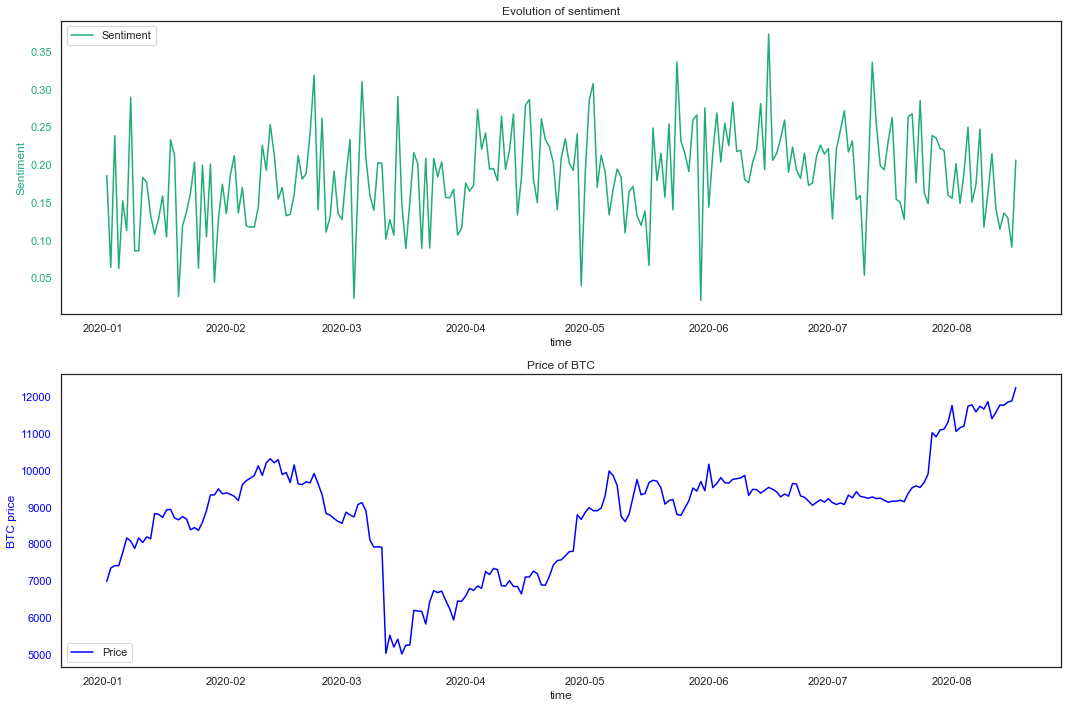

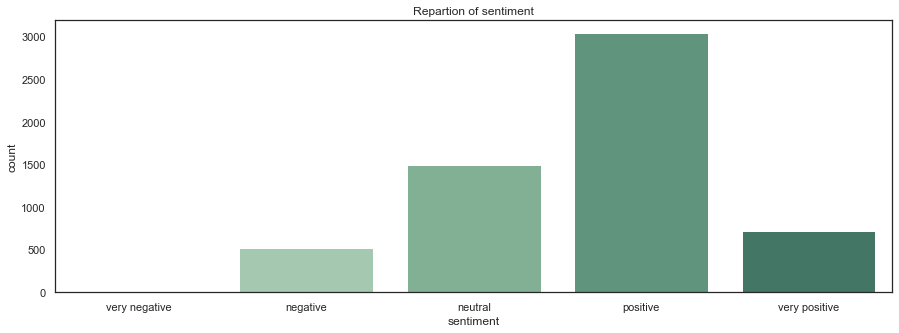

In [70]:
group_day = sentiment_data.groupby('day')['polarity'].mean()

# Evolution of sentiment
if get_price_info:
    fig, ax = plt.subplots(2, 1, figsize=(15,10))
    sns.lineplot(group_day.index, group_day.values, color='#1fad73', ax=ax[0], label='Sentiment')
    ax[0].set_title("Evolution of sentiment")
    ax[0].set_xlabel('time')
    ax[0].tick_params(axis='y', labelcolor='#1fad73')
    ax[0].set_ylabel('Sentiment', color='#1fad73')
    ax[0].legend(loc='upper left')

    sns.lineplot(prices[maskinf & masksup].date.values, prices[maskinf & masksup].close.values, ax=ax[1], color='blue', label='Price')
    ax[1].set_title(f"Price of {coin_symbol}")
    ax[1].set_ylabel(f'{coin_symbol} price', color='blue')  # we already handled the x-label with ax1
    ax[1].set_xlabel('time')
    ax[1].tick_params(axis='y', labelcolor='blue')
    ax[1].legend(loc=3)

else:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(group_day.index, group_day.values, color='#1fad73', ax=ax, label='Sentiment')
    ax.set_title("Evolution of sentiment")
    ax.set_xlabel('time')
    ax.tick_params(axis='y', labelcolor='#1fad73')
    ax.set_ylabel('Sentiment', color='#1fad73')
    ax.legend(loc='upper left')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



# Distribution of sentiment
plt.figure(figsize=(15,5))
sns.countplot(sentiment_data.sentiment, order=['very negative', 'negative', 'neutral', 'positive', 'very positive'],\
             palette=sns.color_palette("ch:2.5,-.2,dark=.3"))
plt.title("Repartion of sentiment")
plt.show()

## Saving Data